<a href="https://colab.research.google.com/github/KenSasaki/Advance/blob/master/Day2_CNN_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from IPython.display import Image, display_png

# digitsデータを使うためにimportする
from torchvision.datasets import MNIST
import torchvision

## GPUを使える場合はGPUを使うための準備

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cpu


## 画像分類をPyTorchで実装する際のステップは以下の通り
- step1: データの読み込み
- step2: ネットワークの定義
- step3: 損失関数の定義 
- step4: 最適化関数の定義
- step5: 学習（講義コードはここまで）
- step6: 学習したネットワークを使って未知データの予測

## step1: データの読み込み
---
trainデータとtestデータをダウンロード

In [3]:
trainset = MNIST(root='./data',
                     train=True,
                     download=True,
                transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                ]))

testset = MNIST(root='./data',
                    train=False,
                    download=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
print(trainset.train_data.shape)
print(trainset.train_labels)

print(testset.test_data.shape)
print(testset.test_labels)

torch.Size([60000, 28, 28])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([10000, 28, 28])
tensor([7, 2, 1,  ..., 4, 5, 6])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Target:  tensor(4)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


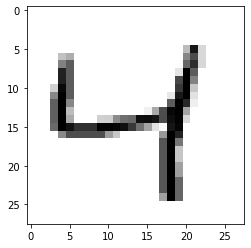

In [5]:
idx = 2
plt.imshow(trainset.train_data[idx], cmap=plt.cm.gray_r, interpolation='nearest')
print("Target: ", trainset.train_labels[idx])

## DataLoaderを作成
---
TensorDatasetは特徴量Xとラベルyをまとめるデータ構造です。<br>
そのTensorDatasetをDataLoaderに渡すことで、forループでデータの一部のみを受け取れるようにします。

In [0]:
train_loader = DataLoader(trainset, batch_size=50, shuffle=True)

In [0]:
test_loader = DataLoader(trainset, batch_size=50, shuffle=True)

## Step2:  CNNのネットワークを定義する（ネットワークの定義）

### CNNを実行するために必要なパーツ
Max Pooling : nn.MaxPool2d()<br>
Average Pooling : nn.AvgPool2d()
Convolution : nn.Conv2d()<br>

In [8]:
# Max Pooling : nn.MaxPool2d()
sample_data = torch.rand([10, 1, 28, 28])
m = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
m(sample_data).shape

torch.Size([10, 1, 14, 14])

In [9]:
# Average Pooling : nn.AvgPool2d()
sample_data = torch.rand([10, 1, 28, 28])
m = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
m(sample_data).shape

torch.Size([10, 1, 14, 14])

In [10]:
# Convolution : nn.Conv2d()
sample_data = torch.rand([10, 1, 28, 28])
m = nn.Conv2d(in_channels=1, out_channels=28, kernel_size=2, stride=1, padding=0)
m(sample_data).shape

torch.Size([10, 28, 27, 27])

### 全結合にするためのFlattenクラスを定義しておく

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)

In [0]:
net = nn.Sequential(
    # inputはチャンネル数: 1　ピクセル数:  28 × 28
    # outputはチャンネル数: 28　ピクセル数:  27 × 27
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=2),
    nn.ReLU(),
    
    # inputはチャンネル数: 28　ピクセル数:  27 × 27
    # outputはチャンネル数: 28　ピクセル数:  13 × 13
    nn.MaxPool2d(kernel_size=2),
    
    
    # inputはチャンネル数: 28　ピクセル数:  13 × 13
    # outputはチャンネル数: 32　ピクセル数:  12 × 12
    nn.Conv2d(in_channels=28, out_channels=32, kernel_size=2),
    nn.ReLU(),
    
    # inputはチャンネル数: 32　ピクセル数:  12 × 12
    # outputはチャンネル数: 32　ピクセル数:  6 × 6
    nn.MaxPool2d(kernel_size=2),
    
    # inputはチャンネル数: 32　ピクセル数:  6× 6
    # outputは32×6 × 6
    Flatten()
)

### （参考）フラットにした直後の次元数を確認するためにサンプルデータを生成

In [13]:
sample_data = torch.rand([10, 1, 28, 28])
sample_data.shape
# [データ数, チャンネル数, ピクセル数, ピクセル数]
# チャンネル数: 1チャンネルならば白黒、3チャンネルならばRGB

torch.Size([10, 1, 28, 28])

In [14]:
print(net(sample_data).shape)

torch.Size([10, 1152])


## ネットワークの定義

In [0]:
net = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=28, out_channels=32, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    Flatten(),
    
    # 1152 は Flatten() の出力と対応している。
    # 32チャンネル × 6ピクセル × 6ピクセル
    nn.Linear(1152, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

## GPUに転送
---
GPUはCPUと違って、計算処理を順番に行うのではなく、並行化して行うことができます。<br>
Deep Learningでは膨大な量の行列計算を行うので、GPUを利用し並列化して計算を行うと高速化が見込めます。

In [0]:
net = net.to(device)

## Step3: 目的関数に交差エントロピー誤差関数を用意（損失関数の定義）

In [17]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


## Step4: Optimizerを定義する（最適化関数の定義）
---
今回はSGDを利用します。

In [0]:
optimizer = optim.SGD(net.parameters(), lr=0.1)

## step5: 学習

In [19]:
train_loss_track = []
test_loss_track = []

for epoc in range(5):
    running_loss = 0
    running_test_loss = 0
    
    # 学習モード
    net.train()
    for step, (xx, yy)  in enumerate(train_loader):
        
        # device = "cuda"の場合、GPUにデータを転送する
        xx = xx.to(device)
        yy = yy.to(device)
        
        # 最後に計算した各パラメーターの勾配を初期化する
        optimizer.zero_grad()
        
        # フォワード計算を行う
        y_pred = net(xx)
        
        # 誤差関数を使ってギャップの計測
        loss = loss_func(y_pred, yy)
        
        # 誤差逆伝播法を使って自動微分
        loss.backward()
        
        # パラメーターを更新
        optimizer.step()
        
        # 学習データを使って損失を計算
        running_loss += loss.item()
        
        if step % 100 == 0:
            print('[{:d}, {:5d}] loss: {}'
                    .format(epoc + 1, step + 1, running_loss / 100))
            running_loss = 0.0
        
    # エポックが終了したら平均損失を計算
    train_loss_track.append(running_loss / (step + 1))
    
    #評価（evaluation）モード
    net.eval()
    
    with torch.no_grad():
        for step, (xx_test, yy_test)  in enumerate(test_loader):

            # device = "cuda"の場合、GPUにデータを転送する
            xx_test = xx_test.to(device)
            yy_test = yy_test.to(device)

            # 予測値を計算
            y_pred = net(xx_test)

            # 誤差関数を使ってギャップの計測
            test_loss = loss_func(y_pred, yy_test)
            
            # テストデータを使って損失を計算
            running_test_loss += test_loss.item()

        # 誤差をトラッキング
        test_loss_track.append(running_test_loss / (step + 1))

[1,     1] loss: 0.023042004108428955
[1,   101] loss: 1.9457999289035797
[1,   201] loss: 0.7229252772033214
[1,   301] loss: 0.40081130400300025
[1,   401] loss: 0.30092346251010893
[1,   501] loss: 0.22443439822643996
[1,   601] loss: 0.16646586541086436
[1,   701] loss: 0.16841419341042638
[1,   801] loss: 0.1215343614667654
[1,   901] loss: 0.11202880344353616
[1,  1001] loss: 0.11796828037127853
[1,  1101] loss: 0.116090407371521
[2,     1] loss: 0.00030304595828056335
[2,   101] loss: 0.08611346823163331
[2,   201] loss: 0.09352488942444324
[2,   301] loss: 0.08175290948711336
[2,   401] loss: 0.08636801119893789
[2,   501] loss: 0.07247507977299392
[2,   601] loss: 0.07642295878846199
[2,   701] loss: 0.08230308020487427
[2,   801] loss: 0.0742238889541477
[2,   901] loss: 0.07785490471869708
[2,  1001] loss: 0.07675514035392553
[2,  1101] loss: 0.08993819167371839
[3,     1] loss: 0.0004990315064787865
[3,   101] loss: 0.057274291077628735
[3,   201] loss: 0.06952107182703912


## 交差エントロピー誤差の推移

In [0]:
plt.plot(train_loss_track)

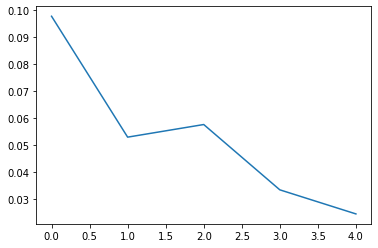

In [21]:
plt.plot(test_loss_track)

## testデータでAccuracyを計算

In [26]:
true = 0
total = 0

all_labels = np.array([])
all_preds = np.array([])

with torch.no_grad():
    for test_xx, test_yy in test_loader:
        
        # device = "cuda"の場合、GPUにデータを転送する
        test_xx = test_xx.to(device)
        test_yy = test_yy.to(device)

        outputs = net(test_xx)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels = np.append(all_labels, test_yy.cpu().data.numpy())
        all_preds = np.append(all_preds, predicted.cpu().numpy())
        
        total += test_yy.size(0)
        true += (predicted == test_yy).sum().item()
print('Accuracy: {:.2f} %'.format(100 * float(true/total)))

Accuracy: 99.28 %


## testデータで混同行列を作成

In [24]:
labels = np.unique(all_labels)
cm = confusion_matrix(all_labels, all_preds, labels=labels)
cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
cm_labeled

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0.0,1850,0,1,0,0,0,3,0,0,1
1.0,0,2017,0,0,0,0,1,1,0,1
2.0,0,2,1885,1,2,0,0,4,2,2
3.0,2,2,1,1843,0,5,0,2,6,2
4.0,0,2,0,0,1771,0,0,0,0,15
5.0,0,0,0,3,0,1722,8,0,3,1
6.0,3,2,0,1,2,0,1822,0,0,0
7.0,0,2,1,1,0,0,0,1918,0,9
8.0,5,2,1,0,2,3,0,1,1729,3
9.0,0,0,0,0,2,1,0,8,5,1816


## 【ご参考】その他レイヤー 活性化関数

(-0.5, 1.5)

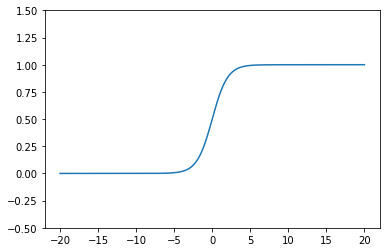

In [25]:
# nn.Sigmoid
x = torch.linspace(-20, 20, 300, dtype=torch.float)
ac = nn.Sigmoid()
y = ac(x)
plt.plot(x.numpy(), y.numpy(), label='')
plt.ylim((-0.5, 1.5))

(-1.5, 1.5)

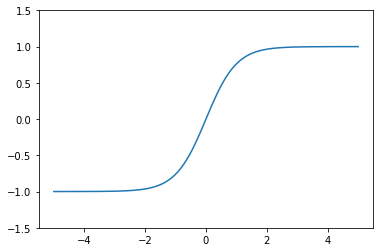

In [28]:
# nn.Tanh
x = torch.linspace(-5, 5, 200, dtype=torch.float)
ac = nn.Tanh()
y = ac(x)
plt.plot(x.numpy(), y.numpy(), label='')
plt.ylim((-1.5, 1.5 ))

(-5, 5)

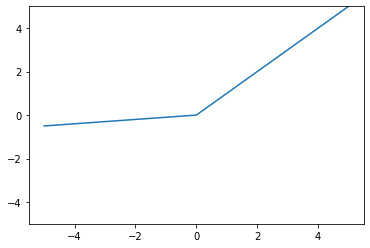

In [29]:
# nn.LeakyReLU
# Day3で紹介するGANで利用されます
x = torch.linspace(-5, 5, 200, dtype=torch.float)
ac = nn.LeakyReLU(0.1)
y = ac(x)
plt.plot(x.numpy(), y.numpy(), label='')
plt.ylim((-5, 5))